# Modelowanie akustyczne w rozpoznawaniu mowy

Na tym ćwiczeniu podamy przykład modelowania akustycznego jakie używamy w rozpoznawaniu mowy. Problem ten zostanie przedstawiony na podstawie problemu klasyfikacji fonemów na poszczególnych ramakach sygnału.

Zacznijmy od zaimportowania numy i matplotlib:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Zaimportujmy też następujące klasy i moduły:

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.utils import to_categorical
import pickle

Ściągniemy następujące pliki i programy:
Podłącz dysk Google i umieść w nim następujące pliki:|

- corpus.npy - podzbiór większego korpusu mowy. Plik ten zawiera cechy MFCC zapisane jako binanry plik NumPy
- indices_small.pkl - indeksy do podziału tego zbioru na train/valid/test w formacie pickle
- phones.txt - lista fonemów użyta w pliku HDF5 (tam dla oszczędności użyto indeksy zamiast stringów)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
path = '/content/drive/MyDrive/colab_data/corpus.npy'

In [6]:
cd drive/MyDrive/colab_data

/content/drive/MyDrive/colab_data


In [7]:
ls


'AMsimple (1).ipynb'   corpus.npy   indices_small.pkl   phones.txt


Wczytaj dane z pliku `corpus.npy`. W tym celu należy otworzyć ten plik jako binarny i na jego deskryptorze 2 razy uruchomić metodę `np.load`. Pierwszy raz otrzymamy tablicę cech (danych wejściowych do modelu), a druga tablica to etykiety (dane wyjściowe). Ze względu na sposób zapisania danych konieczne jest dopisanie argumentu `allow_pickle=True`.

In [10]:
with open(path, 'rb') as f:
    x = np.load(f, allow_pickle=True)
    y = np.load(f, allow_pickle=True)

Wypisz rozmiary tych tablic:

In [11]:
print(x.shape)
print(y.shape)

(1327,)
(1327,)


Wypisz wartość dowolnej wypowiedzi z tego korpusu:

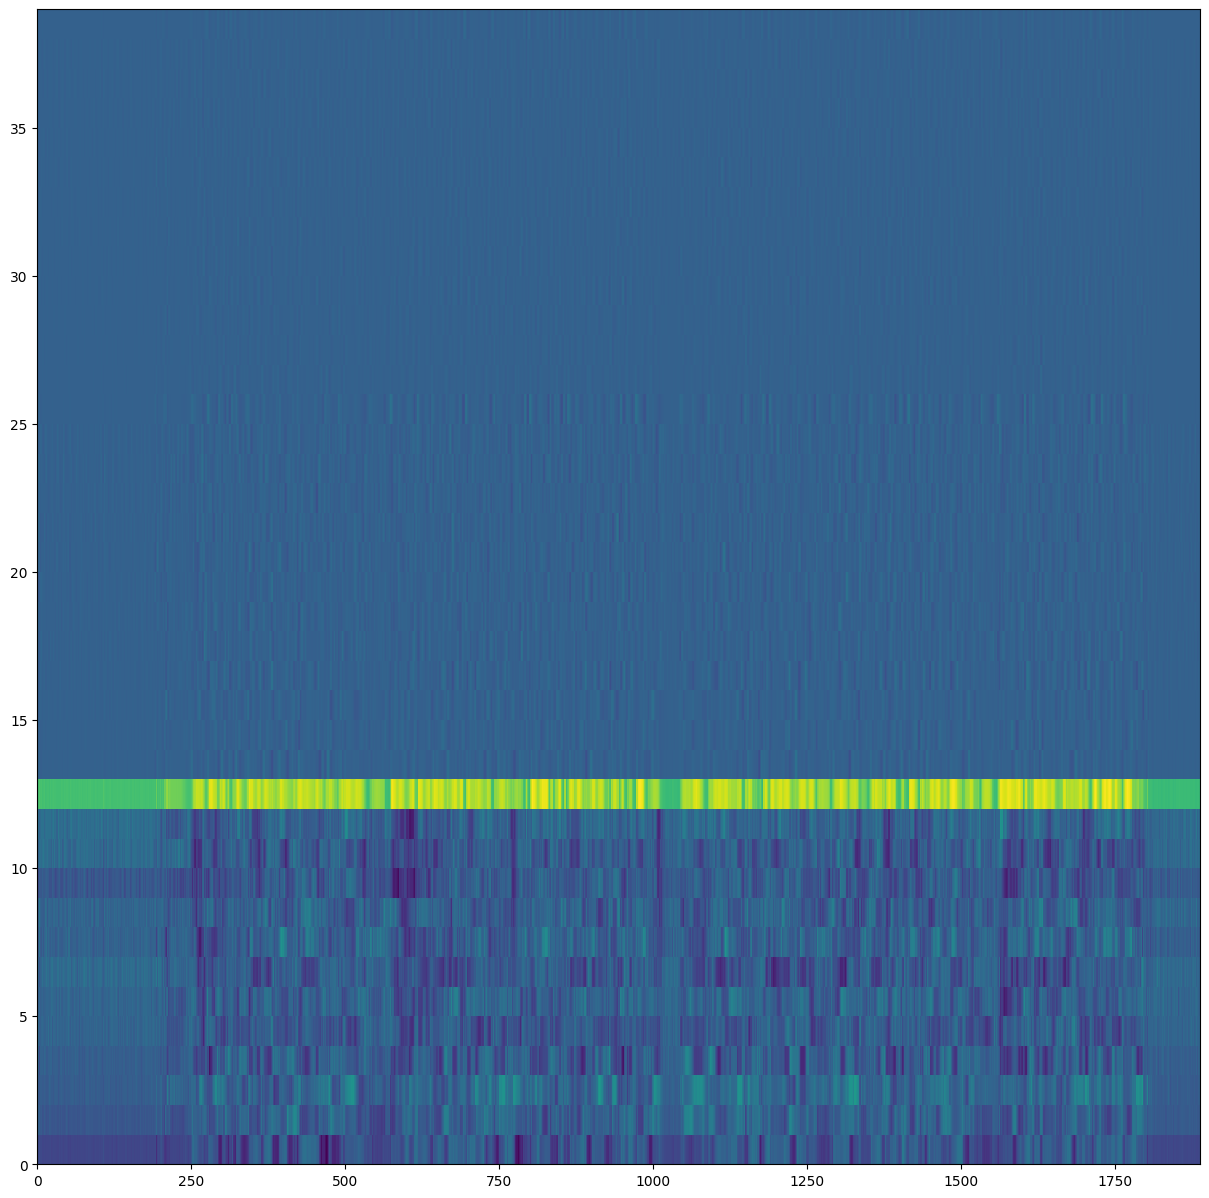

In [22]:
figure(figsize=(15, 15))
pcolormesh(x[101].T)

Wczytaj plik 'phones.txt' i stwórz mapę zamieniającą indeksy fonemów na tekst:

In [14]:
print(list(y[0]))

[np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.int64(26), np.in

In [15]:
ph_map = {}
with open('phones.txt', 'r') as f:
    for line in f:
      token = line.strip().split()
      ph_map[int(token[0])] = token[1]
ph_map

{0: 'I',
 1: 'S',
 2: 'Z',
 3: 'a',
 4: 'b',
 5: 'd',
 6: 'dZ',
 7: 'dz',
 8: 'dzi',
 9: 'e',
 10: 'en',
 11: 'f',
 12: 'g',
 13: 'i',
 14: 'j',
 15: 'k',
 16: 'l',
 17: 'm',
 18: 'n',
 19: 'ni',
 20: 'o',
 21: 'on',
 22: 'p',
 23: 'r',
 24: 's',
 25: 'si',
 26: 'sil',
 27: 't',
 28: 'tS',
 29: 'ts',
 30: 'tsi',
 31: 'u',
 32: 'v',
 33: 'w',
 34: 'x',
 35: 'z',
 36: 'zi'}

Wypisz fonemy dowolnej wypowiedzi w postaci tekstowej:

In [16]:
print([ph_map[x] for x in y[0]])

['sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil', 'sil'

Wczytaj indeksy w formacie pickle. Użyj te indeksy do podzielenia korpusu na części: `tr_x`, `tr_y`, `dev_x`, `dev_y` oraz `tst_x`, `tst_y`.

Dla każdego podzbioru, połącz wszystkie wypowiedzi w jedną długą tablicę. Dla tablic X użyj metody `vstack`, a dla Y użyj `concatenate`.

In [17]:
with open('indices_small.pkl', 'rb') as f:
    idx = pickle.load(f)

Wypisz rozmiary wszystkich tablic:

In [18]:
tr_x = vstack(x[idx['train']])
tr_y = concatenate(y[idx['train']])

dev_x = vstack(x[idx['dev']])
dev_y = concatenate(y[idx['dev']])

tst_x = vstack(x[idx['test']])
tst_y = concatenate(y[idx['test']])


In [19]:
print(tr_x.shape)
print(tr_y.shape)

print(dev_x.shape)
print(dev_y.shape)

print(tst_x.shape)
print(tst_y.shape)

(1500773, 39)
(1500773,)
(171093, 39)
(171093,)
(186336, 39)
(186336,)


## Zmienne globalne

Ustalmy pewne globalne zmienne przydatne do obliczeń:

- input_dim - ilość cech w jednej ramce - można wyliczyć z którejś tablicy X
- output_dim - ilość różnych fonemów - można wyliczyć z rozmiaru mapy fonemów
- hidden_num - szerokość wartswy ukrytej modelu (np 256)
- batch_size - ilość próbek w jednym batchu (niech to będzie 256)
- epoch_num - ilość epok

In [23]:
input_dim = tr_x.shape[1]
output_dim = len(ph_map)
hidden_num = 256
batch_size = 256
epoch_num = 10

Zamień tablice Y na tablicę zawierające kodowanie 'one-hot': `tr_y` przepisz do `tr_y_oh`, `dev_y` na `dev_y_oh`, a `tst_y` na `tst_y_oh`.

Do konwersji użyj metody `to_categorical`. Nie zapomnij ustawić argument `num_classes` w wywołaniu tej funkcji.

In [24]:
tr_y_oh = to_categorical(tr_y, num_classes=output_dim)
dev_y_oh = to_categorical(dev_y, num_classes=output_dim)
tst_y_oh = to_categorical(tst_y, num_classes=output_dim)

print(tr_y_oh[:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

## Model

Stwórz model typu `Sequential`. Dodaj do niego dwie warstwy typu `Dense`:

- pierwsza ma mieć `input_dim` równy zmiennej globalnej `input_dim`, `units` ma odpowiadać `hidden_num`, a funkcja aktywacji niech będzie `sigmoid`.
- druga ma mieć `units` równy `output_dim`, a funkcja aktywacji ma być  `softmax`

Ustaw zmienne:

- `optimizer` ustaw na `Adadelta()`
- `loss` na `categorical_crossentropy`
- `metrics` na listę: `['acc']`

In [25]:
model = Sequential()

model.add(Dense(input_dim=input_dim, units=hidden_num, activation='sigmoid'))
model.add(Dense(units=output_dim, activation='softmax'))

optimizer = Adadelta()
loss = 'categorical_crossentropy'
metrics = ['acc']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Skommpiluj model, ustawiając odpowiednio `loss`, `optimizer` i `metrics`.

Użyj metody `summary()` do wyświetlenia statystyk modelu:

In [26]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         9,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,749 (77.14 KB)

 Trainable params: 19,749 (77.14 KB)

 Non-trainable params: 0 (0.00 B)

Użyj również metody `plot_model` z `keras.utils` do zapisania rysunku z modelem do pliku. Potem użyj metody `Image` z `IPython.display` do wyświetlenia tego obrazu.

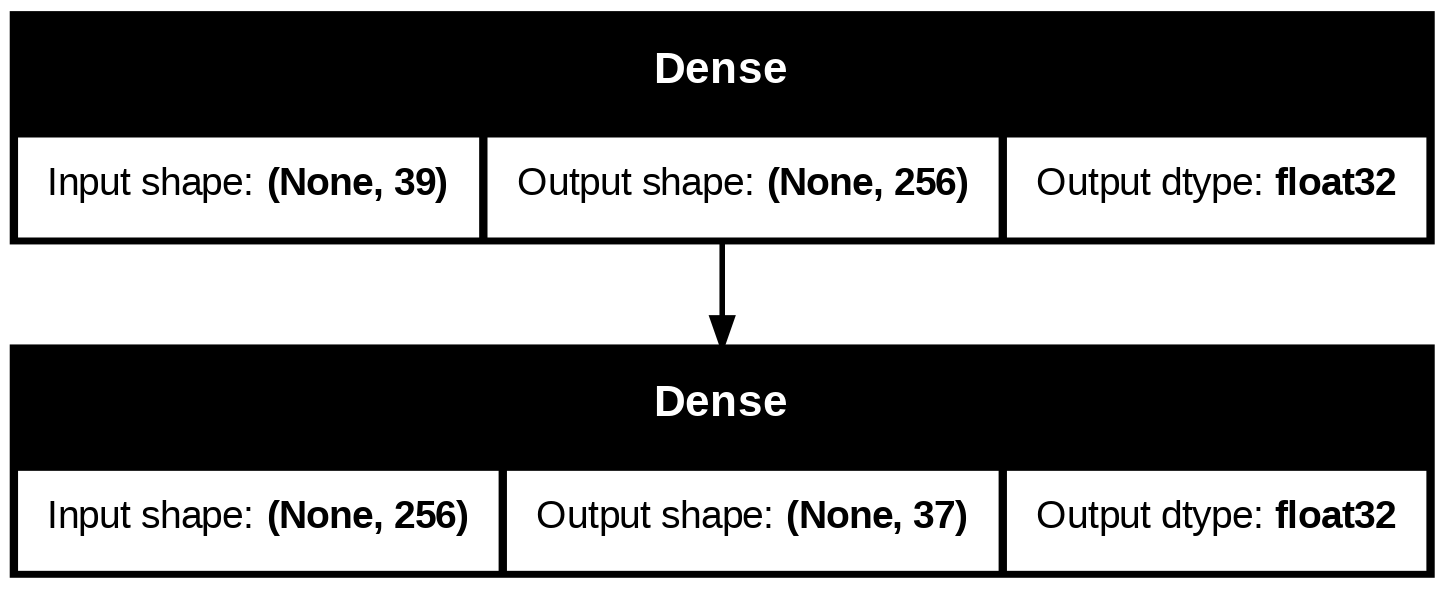

In [27]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, show_shapes=True, show_dtype=True)


## Trenowanie

Teraz możemy zacząć z trenowaniem. Zrób najpierw zmienną o nazwie `val` zawierającą parę `(x,y)` z danymi z podzbioru dev.

Uruchom metodę `fit` modelu podając odpowiednio:

- jako 2 pierwsze argumenty X i Y zbioru treningowego
- parametr `shuffle` ustaw na `True`
- parametr `batch_size` ustaw na globalną zmienną `batch_size`
- parametr `epochs` ustaw na `epoch_num`
- parametr `verbose` można ustawić na 1, żeby zobaczyć progress
- parametr `validation_data` ustaw na wyżej utworzoną parę `val`

Funkcja ta zwróci objekt który nazwijemy `hist`.

In [28]:
from re import VERBOSE
hist = model.fit(
    tr_x, tr_y_oh,
    shuffle=True,
    batch_size=batch_size,
    epochs=epoch_num,
    verbose=1,
    validation_data=(dev_x, dev_y_oh)
)

Epoch 1/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - acc: 0.1833 - loss: 3.3381 - val_acc: 0.3026 - val_loss: 2.9395
Epoch 2/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - acc: 0.2908 - loss: 2.9418 - val_acc: 0.3026 - val_loss: 2.8779
Epoch 3/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - acc: 0.2903 - loss: 2.8899 - val_acc: 0.3026 - val_loss: 2.8348
Epoch 4/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - acc: 0.2907 - loss: 2.8480 - val_acc: 0.3026 - val_loss: 2.7949
Epoch 5/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - acc: 0.2902 - loss: 2.8097 - val_acc: 0.3026 - val_loss: 2.7567
Epoch 6/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - acc: 0.2900 - loss: 2.7727 - val_acc: 0.3027 - val_loss: 2.7198
Epoch 7/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - acc: 0.2907 - loss: 2.7361 - val_acc: 0.3039 - val_loss: 2.6840
Epoch 8/10
5863/5863 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - acc: 0.2927 - loss: 2.7000 - val_acc: 0.3090 - val_loss: 2.6496
Epoch 9/10
5863/5863 ━━━━━━━━━━━

W objekcie `hist` jest składowa `history`, która jest słownikiem. Narysuj historię `'loss'` używając matplotlib:

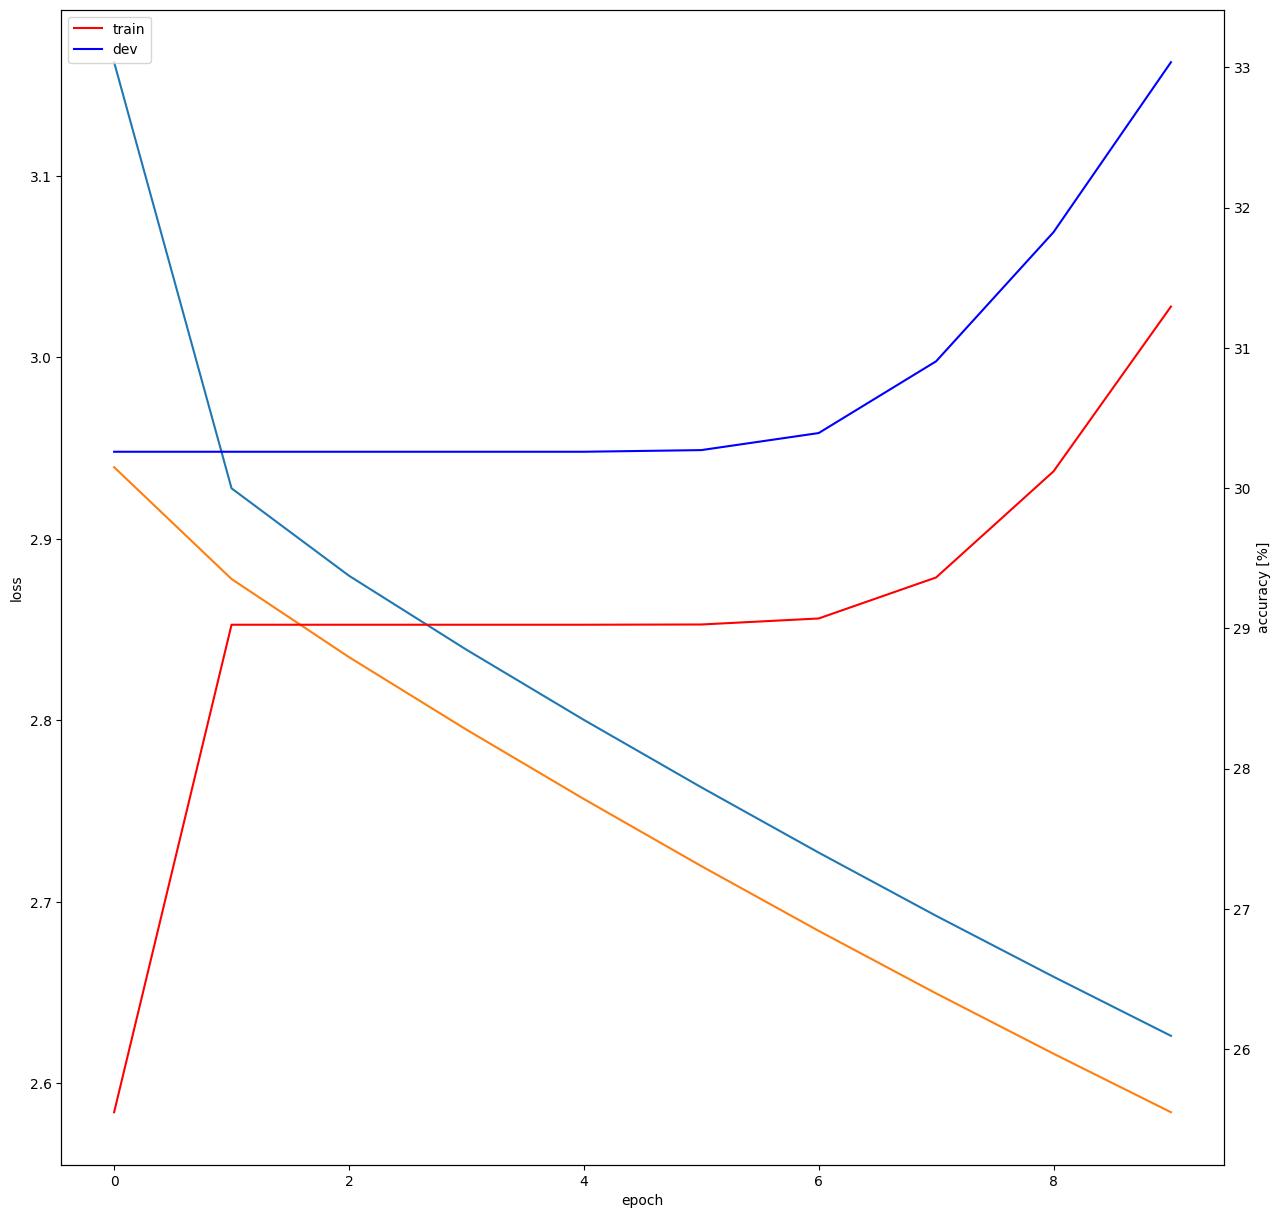

In [29]:
figure(figsize=(15, 15))
plot( hist.history['loss'] )
plot( hist.history['val_loss'] )
ylabel('loss')
xlabel('epoch')

twinx()
plot(100*array(hist.history['acc']),'r',label='train')
plot(100*array(hist.history['val_acc']),'b',label='Vall acc')
ylabel('accuracy [%]')
legend(['train', 'dev'], loc='upper left')


## Ewaluacja

Użyj metody `evaluate` na zbiorze testowym, żeby policzyć jakość modelu.

In [30]:
eval = model.evaluate(tst_x, tst_y_oh)


5823/5823 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - acc: 0.3125 - loss: 2.6313


Powyższa metoda zwraca parę wartości. Pierwszy element tej pary to Loss, a drugi Accuracy. Wypisz te dwie wartości:

In [31]:
print(f'Loss: {eval[0]}')
print(f'Accuracy: {eval[1]}')

Loss: 2.6172945499420166
Accuracy: 0.3167503774166107


Powyższym obliczeniem w bardzo łatwy sposób może policzyć jakość modelu, ale żeby zwrócić dokładnie wynik działania modelu, należy użyć metody `predict`.

In [32]:
evalt = model.predict(tst_x)
evalt

5823/5823 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


array([[0.01668299, 0.01273952, 0.00915239, ..., 0.0084549 , 0.01204695,
        0.00164146],
       [0.01687407, 0.01244618, 0.0089835 , ..., 0.00813828, 0.01254368,
        0.00164107],
       [0.01868143, 0.01397088, 0.00982147, ..., 0.00888839, 0.0134394 ,
        0.00174216],
       ...,
       [0.01497516, 0.0105944 , 0.00796849, ..., 0.00743774, 0.01086305,
        0.00141904],
       [0.01507504, 0.01075681, 0.00809561, ..., 0.0070868 , 0.01110885,
        0.00141152],
       [0.01556293, 0.01110092, 0.00814401, ..., 0.00752366, 0.0113482 ,
        0.00146096]], dtype=float32)

In [33]:
tst_outpu = model.predict(tst_x)

5823/5823 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


In [34]:
tst_outpu = np.argmax(tst_outpu, axis=1)
tst_outpu

array([26, 26, 26, ..., 26, 26, 26])

Narysuj macierz konfuzji używając wyniku rozpoznanych klas z metody powyżej.

In [35]:
mt = zeros((output_dim,output_dim))

for p,r in zip(tst_y, tst_outpu):
  mt[p,r] += 1

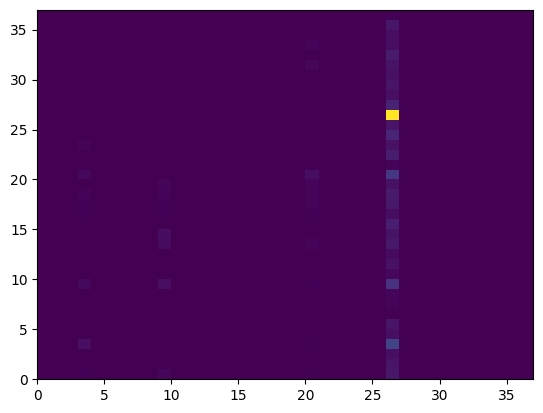

In [36]:
pcolormesh(mt)

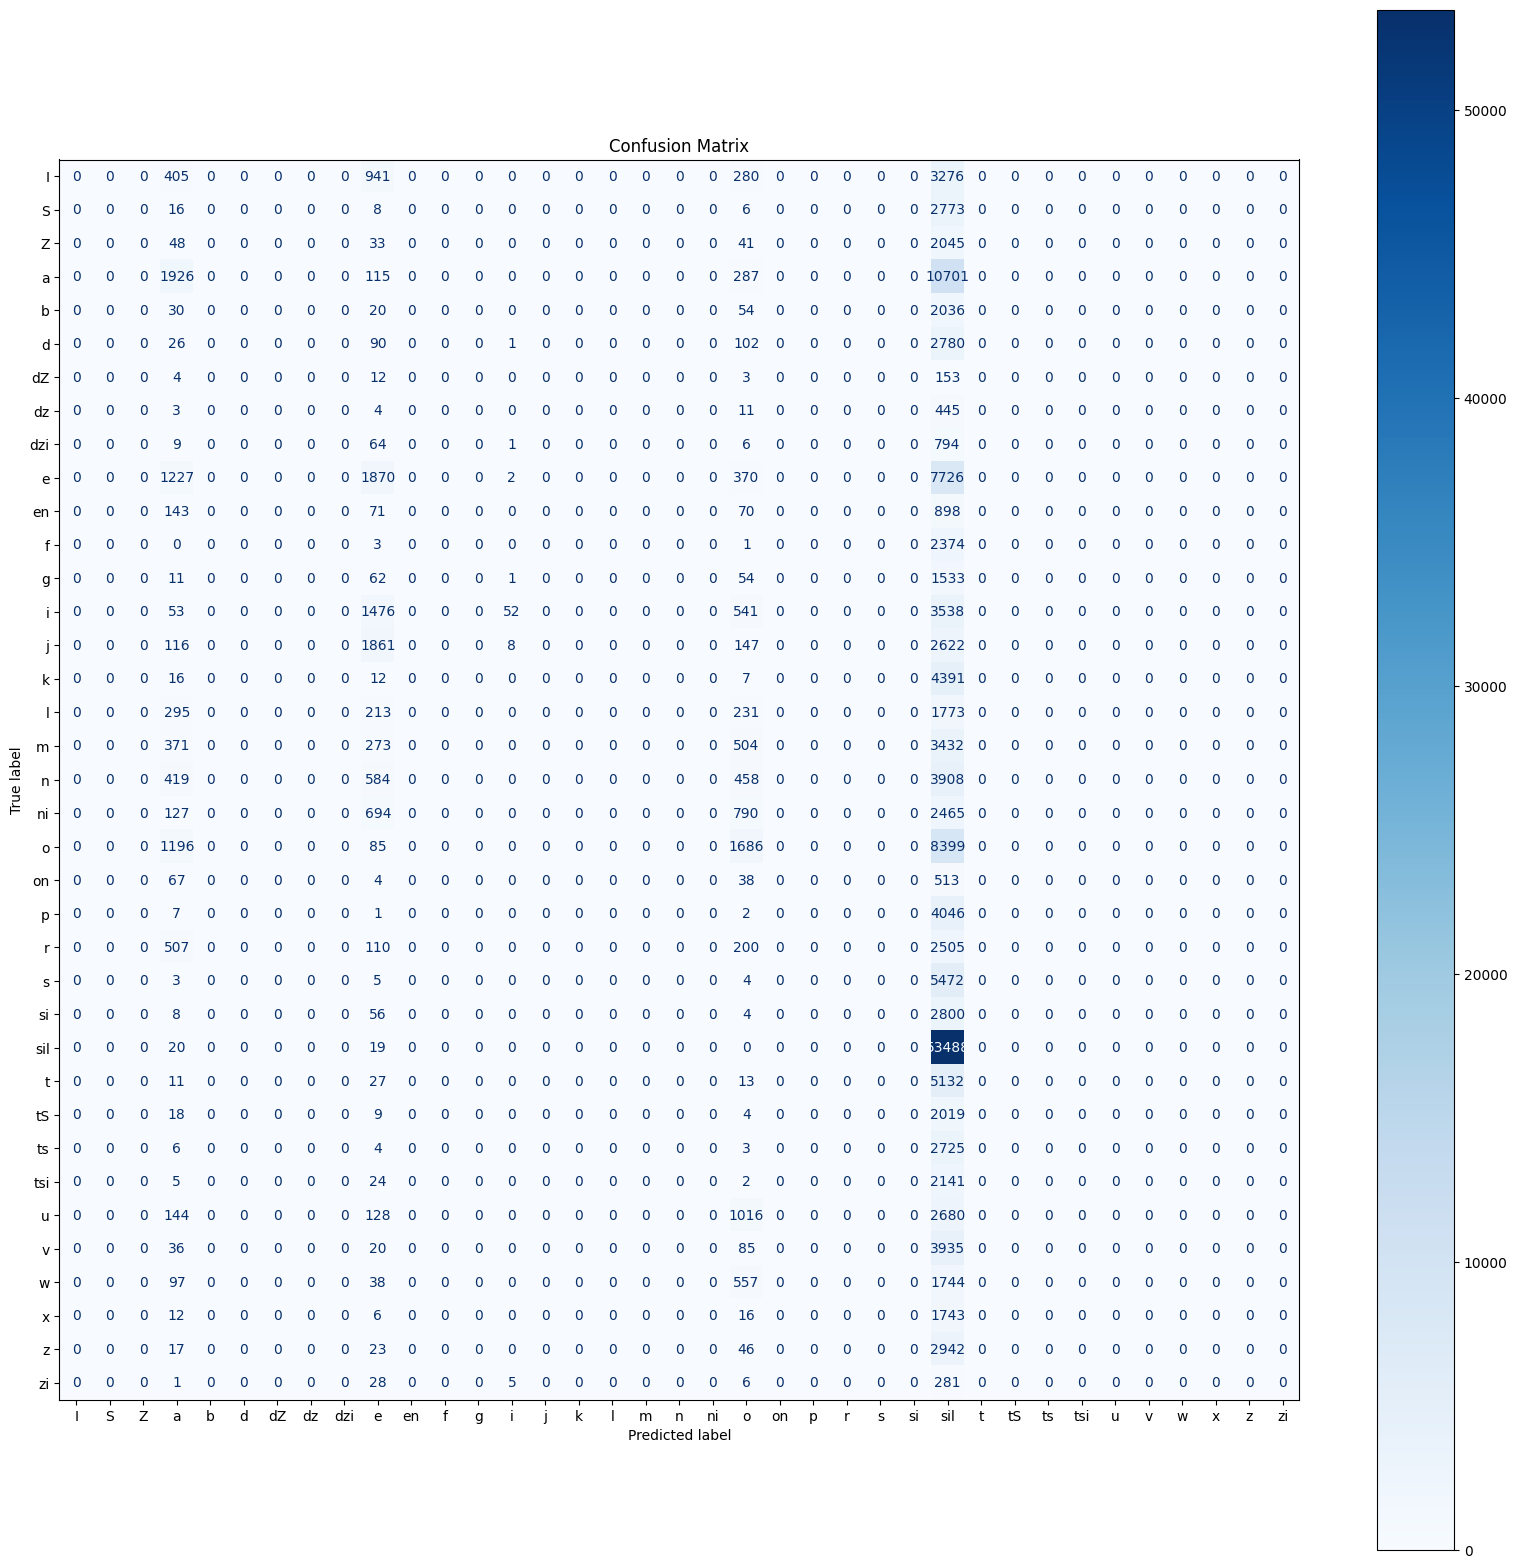

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_classes = np.argmax(evalt, axis=1)

true_classes = tst_y
cm = confusion_matrix(true_classes, predicted_classes)

labels = [ph_map[i] for i in sorted(ph_map.keys())]

fig, ax = plt.subplots(figsize=(20, 20))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

# Dodatkowe pomysły

1. różne algorytmy optymalizacyjne
2. różne topologie sieci typu feed forward, np. dropout albo sieci splotowe
3. kotektst, czyli podawanie więcej ramek na wejściu
4. sieci rekurencyjne